In [699]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec, KeyedVectors


warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [700]:
train_df = pd.read_csv('data/train.csv')

In [701]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [702]:
train_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
195531,195531,295988,295989,How I want to spy other people's WeChat passwo...,What do you do to spy on WeChat without rooting?,1
95529,95529,159301,159302,How can I learn to focus more on my work?,What should I do to be more focused on my work?,1
100781,100781,156311,167094,Could Taiwan rename itself (not related to Chi...,Why does China bully Taiwan?,0
156613,156613,245082,245083,How to review Bollywood movies ?,What is your review of Bollywood Movies?,0
262817,262817,379240,379241,What are the real world applications of variou...,What are some real-world applications of a sta...,0


In [703]:
train_df.shape

(404290, 6)

In [704]:
train_df.duplicated().sum()

0

In [705]:
train_df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [706]:
train_df.dropna(axis=0, inplace=True)

In [707]:
train_df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
299719,299719,422414,422415,Why don't people trust actors?,Why don't gay American people in society like ...,0
36694,36694,66883,66884,"When castes are based on one's occupation, why...","If caste is not based on birth in Hinduism, th...",0
196012,196012,45086,152854,What are some of the best Hindi dubbed South I...,What are some funniest South Indian movie titl...,0
115837,115837,188815,188816,Will the i5 6400 be a bottleneck to the GTX 1070?,Will a core i5 65xx bottleneck a GTX 1070 when...,0
223350,223350,249575,331138,Do congressmen and senators fly commercial?,Senators and congressmen need to travel a lot ...,0


In [708]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


is_duplicate
0    255024
1    149263
Name: count, dtype: int64


<Axes: xlabel='is_duplicate'>

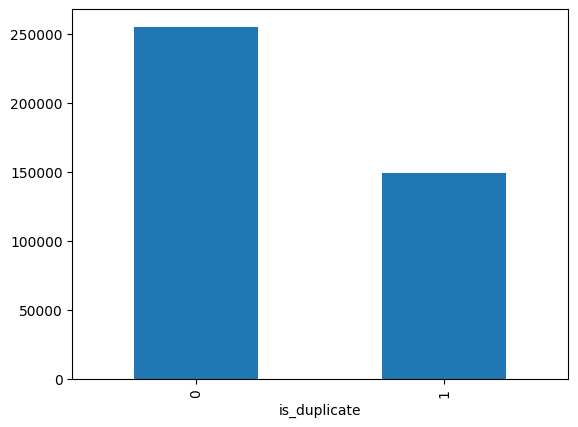

In [709]:
print(train_df['is_duplicate'].value_counts())
train_df['is_duplicate'].value_counts().plot(kind='bar')

In [710]:
qid = pd.Series(train_df['qid1'].to_list() + train_df['qid2'].to_list())
print('Number of total unique questions: ', np.unique(qid).shape[0])
x = qid.value_counts() > 1
print('Number of duplicated questions: ', x[x].shape[0])

Number of total unique questions:  537929
Number of duplicated questions:  111778


Text(0, 0.5, 'Number of questions')

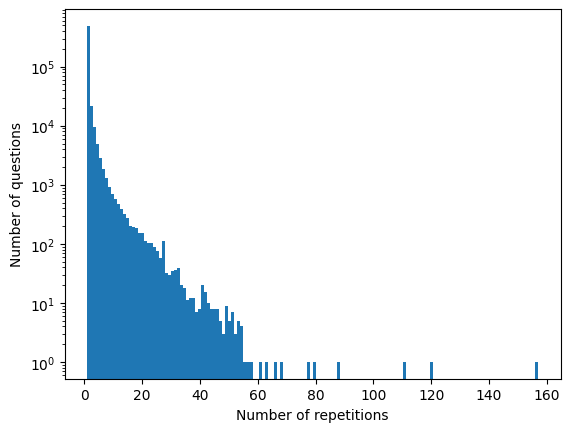

In [711]:
plt.hist(qid.value_counts(), bins=150)
plt.yscale('log')
plt.xlabel('Number of repetitions')
plt.ylabel('Number of questions')

In [712]:
# question1 = ' '.join(train_df['question1'])
# question2 = ' '.join(train_df['question2'])
# cloud1 = WordCloud().generate(question1)
# cloud2 = WordCloud().generate(question2)
# plt.figure(figsize=(15, 10))
# plt.imshow(cloud1)
# plt.axis('off')
# plt.figure(figsize=(15, 10))
# plt.imshow(cloud2)
# plt.axis('off')

In [713]:
df = train_df.sample(30000, random_state=42)
df.shape

(30000, 6)

In [714]:
(df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100

is_duplicate
0    63.09
1    36.91
Name: count, dtype: float64

In [715]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('watches')

'watch'

In [716]:
def preprocess(q):

    # convert to lowercase
    q = q.strip().lower()

    # replace special characters with their names
    q = q.replace("%", " percent")
    q = q.replace("$", " dollar ")
    q = q.replace('₹', " rupee ")
    q = q.replace('€', " euro ")
    q = q.replace("@", " at " )


    # replace [math] with nothing
    q = q.replace('[math]', '')


    # replace large numbers with string equivalents
    q = q.replace(" ,000", "k ")
    q = q.replace(" ,000,000", "m ")
    q = q.replace(" ,000,000,000", "b ")
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)


    # remove HTML tags
    q = re.sub(r'<[^>]+>', '', q)


    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953

    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
        }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]
        
        q_decontracted.append(word)


    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # remove punctuation
    q = re.sub(r'[^\w\s]', '', q)

    q = ' '.join([lemmatizer.lemmatize(word) for word in q.split()])

    return q

In [717]:
preprocess("<h1>how are you've not called since! morning</h1>")

'how are you have not called since morning'

In [718]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [719]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career option doe one have after completi...,0
384863,384863,28901,233483,what are some good book on marketing,what are some of the best book ever written ab...,1


1. Token Features
- **cwc_min:** Ratio of number of common words to the length of the smaller question.
- **cwc_max:** Ratio of number of common words to the length of the longer question.
- **csc_min:** Ratio of number of common stop words to the length of the smaller question.
- **csc_max:** Ratio of number of common stop words to the length of the larger question question.
- **ctc_min:** Ratio of number of common tokens to the length of the smaller question.
- **ctc_min:** Ratio of number of common tokens to the length of the larger question.
- **last_word_eq:** 1 id the last word of both sentences is the same. 0 otherwise.
- **first_word_eq:** 1 id the first word of both sentences is the same. 0 otherwise.

In [720]:
from nltk.corpus import stopwords


def get_token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    token_features = [0.0]*8

    # get tokens in both questions
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    STOP_WORDS = stopwords.words('english')

    # get stopwords in both questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # get ordinary words (non-stopwords) in both questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    # number of common tokens in both questions
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    # number of common stop words in both tokens
    common_stopword_count = len(q1_stops.intersection(q2_stops))

    # number of common words in both tokens
    common_word_count = len(q1_words.intersection(q2_words))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count/ (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stopword_count/ (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stopword_count/ (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count/ (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count/ (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = 1 if (q1_tokens[-1] == q2_tokens[-1]) else 0
    token_features[7] = 1 if (q1_tokens[0] == q2_tokens[0]) else 0


    return token_features


In [721]:
token_features = df.apply(get_token_features, axis=1)

In [722]:
df['cwc_min'] = list(map(lambda x: x[0], token_features))
df['cwc_max'] = list(map(lambda x: x[1], token_features))
df['csc_min'] = list(map(lambda x: x[2], token_features))
df['csc_max'] = list(map(lambda x: x[3], token_features))
df['ctc_min'] = list(map(lambda x: x[4], token_features))
df['ctc_max'] = list(map(lambda x: x[5], token_features))
df['last_word_eq'] = list(map(lambda x: x[6], token_features))
df['first_word_eq'] = list(map(lambda x: x[7], token_features))

2. Length Features
- **mean_len:** Average token length of both questions
- **abs_len_diff:** Absolute difference in token lengths of both questions
- **longest_substr_ratio:** Ratio of longest common substring in both questions to the token length of smaller question

In [723]:
import distance

# q1 = "how do i play pokémon go in korea"
# q2 = "how do i play pokémon go in china"

def get_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    length_features = [0.0]*3

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # mean token length
    length_features[0] = (len(q1_tokens) + len(q2_tokens))/2

    # absolute difference in length
    length_features[1] = abs(len(q1_tokens) - len(q2_tokens))

    # longest substring ratio
    substrs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(substrs[0]) / ( min(len(q1), len(q2)) + 1)
        
    return length_features


In [724]:
length_features = df.apply(get_length_features, axis=1)

In [725]:
df['mean_len'] = list(map(lambda x: x[0], length_features))
df['abs_len_diff'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

3. Fuzzy Features

In [726]:
from fuzzywuzzy import fuzz

def get_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    fuzzy_features[0] = fuzz.ratio(q1, q2)
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features



In [727]:
fuzzy_features = df.apply(get_fuzzy_features, axis=1)


In [728]:
df['fuzzy_ratio'] = list(map(lambda x: x[0] , fuzzy_features))
df['fuzzy_partial_ratio'] = list(map(lambda x: x[1] , fuzzy_features))
df['token_order_ratio'] = list(map(lambda x: x[2] , fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3] , fuzzy_features))

In [729]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,longest_substr_ratio,fuzzy_ratio,fuzzy_partial_ratio,token_order_ratio,token_set_ratio
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,0.749981,0.749981,0.999975,0.999975,...,0.874989,0,1,8.0,0,0.823529,88,88,81,90
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0,0.499988,0.399992,0.000000,0.000000,...,0.181817,0,0,9.0,4,0.250000,28,49,48,55
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0,0.499988,0.181817,0.000000,0.000000,...,0.095238,0,0,14.0,14,0.400000,34,57,38,53
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career option doe one have after completi...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0,14.5,11,0.066667,21,41,31,32
384863,384863,28901,233483,what are some good book on marketing,what are some of the best book ever written ab...,1,0.666644,0.399992,0.749981,0.499992,...,0.454541,1,1,9.0,4,0.378378,67,61,65,88


In [730]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [731]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [732]:

def total_words(row): 
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))

    return len(w1) + len(w2)

In [733]:
df['words_total'] = df.apply(total_words, axis=1)

In [734]:
def common_words(row): 
    w1 = set(map(lambda word: word.lower().strip() ,row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip() ,row['question2'].split(" ")))

    return len(w1 & w2)

In [735]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,longest_substr_ratio,fuzzy_ratio,fuzzy_partial_ratio,token_order_ratio,token_set_ratio,q1_len,q2_len,q1_num_words,q2_num_words,words_total
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,0.749981,0.749981,0.999975,0.999975,...,0.823529,88,88,81,90,33,33,8,8,16
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0,0.499988,0.399992,0.000000,0.000000,...,0.250000,28,49,48,55,39,62,7,11,17
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0,0.499988,0.181817,0.000000,0.000000,...,0.400000,34,57,38,53,44,114,7,21,27
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career option doe one have after completi...,0,0.000000,0.000000,0.000000,0.000000,...,0.066667,21,41,31,32,44,118,9,20,27
384863,384863,28901,233483,what are some good book on marketing,what are some of the best book ever written ab...,1,0.666644,0.399992,0.749981,0.499992,...,0.378378,67,61,65,88,36,59,7,11,18


In [736]:
df['words_common'] = df.apply(common_words, axis=1)

In [737]:
df['words_shared']= df['words_common']/df['words_total']

In [738]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,fuzzy_partial_ratio,token_order_ratio,token_set_ratio,q1_len,q2_len,q1_num_words,q2_num_words,words_total,words_common,words_shared
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,0.749981,0.749981,0.999975,0.999975,...,88,81,90,33,33,8,8,16,7,0.437500
224279,224279,332326,332327,will a breathing treatment help a cough,how can i help someone that is unconscious but...,0,0.499988,0.399992,0.000000,0.000000,...,49,48,55,39,62,7,11,17,2,0.117647
252452,252452,336023,366789,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...,0,0.499988,0.181817,0.000000,0.000000,...,57,38,53,44,114,7,21,27,2,0.074074
174039,174039,268330,268331,how do you rate 110 and review maruti baleno,what career option doe one have after completi...,0,0.000000,0.000000,0.000000,0.000000,...,41,31,32,44,118,9,20,27,0,0.000000
384863,384863,28901,233483,what are some good book on marketing,what are some of the best book ever written ab...,1,0.666644,0.399992,0.749981,0.499992,...,61,65,88,36,59,7,11,18,5,0.277778


In [739]:
df.shape

(30000, 28)

In [740]:
ques_df = df[['question1', 'question2']]
print(ques_df.shape)
ques_df.head()

(30000, 2)


,question1,question2
8067,how do i play pokémon go in korea,how do i play pokémon go in china
224279,will a breathing treatment help a cough,how can i help someone that is unconscious but...
252452,is kellyanne conway annoying in your opinion,did kellyanne conway really imply that we shou...
174039,how do you rate 110 and review maruti baleno,what career option doe one have after completi...
384863,what are some good book on marketing,what are some of the best book ever written ab...


In [761]:
# nlp = spacy.load("en_core_web_sm")

# def extract_ner_tag(row):
    
#     question1_entities = [(ent.text, ent.label_) for ent in nlp(row['question1']).ents]
#     question2_entities = [(ent.text, ent.label_) for ent in nlp(row['question2']).ents]
    
#     return question1_entities, question2_entities

# ner_tags = df.iloc[:10].apply(extract_ner_tag, axis=1)
# ner_tags

8067                       ([(korea, GPE)], [(china, GPE)])
224279                                             ([], [])
252452    ([(kellyanne conway, PERSON)], [(kellyanne con...
174039    ([(110, CARDINAL), (maruti, CARDINAL)], [(one,...
384863                                             ([], [])
182965    ([(kerala, GPE), (three, CARDINAL)], [(3 day, ...
199717                                             ([], [])
343232    ([], [(first, ORDINAL), (second, ORDINAL), (th...
91165                                  ([], [(india, GPE)])
110222                                             ([], [])
dtype: object

In [748]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# cv = CountVectorizer(max_features=3000)
# questions = df['question1'].to_list() + df['question2'].to_list()
# q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(), 2)
# print(q1_arr.shape, q2_arr.shape)

In [664]:
questions = df['question1'].to_list() + df['question2'].to_list()
tokenized_questions = [q.split() for q in questions]
w2v = Word2Vec(sentences=tokenized_questions, window=10, min_count=1, vector_size=200)

In [665]:
def sentence_to_vector(sentence, model, vector_size):
   
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)


In [666]:
# corpus = [' '.join(q) for q in tokenized_questions]

# tfidf = TfidfVectorizer()
# tfidf.fit_transform(corpus)

# word2tfidf = dict([(w, tfidf.idf_[tfidf.vocabulary_[w]]) for w in tfidf.vocabulary_])


# def sentence_to_tfidf_weighted_word2vec(sentence, word2tfidf, w2v):
    
#     weighted_embeddings = []
#     for word in sentence:
#         if word in w2v.wv.key_to_index and word in word2tfidf:
#             embedding = w2v.wv[word] * word2tfidf[word]
#             weighted_embeddings.append(embedding)

#     if weighted_embeddings:
#         return np.mean(weighted_embeddings, axis=0)
#     else:
#         return np.zeros(w2v.vector_size)
    


In [762]:
vector_size = w2v.vector_size
q1_arr = np.array([sentence_to_vector(doc, w2v, vector_size) for doc in df['question1'].str.split()])
q2_arr = np.array([sentence_to_vector(doc, w2v, vector_size) for doc in df['question2'].str.split()])
q1_arr.shape, q2_arr.shape

((30000, 200), (30000, 200))

In [763]:
q1_df = pd.DataFrame(q1_arr, index=ques_df.index)
q2_df = pd.DataFrame(q2_arr, index=ques_df.index)
temp_df = pd.concat([q1_df, q2_df], axis=1)
print(temp_df.shape)
temp_df.head()

(30000, 400)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
8067,0.173547,-0.089132,-0.154474,-0.125885,0.333778,-0.602758,-0.016800,0.539575,-0.069923,-0.226924,...,-0.158395,-0.119574,-0.395358,-0.742085,0.564927,-0.602484,0.298492,-0.448308,0.065723,-0.508161
224279,-0.142106,-0.105506,0.054046,-0.114220,0.037447,-0.309887,-0.252419,0.587522,-0.139492,-0.262861,...,-0.127117,-0.255070,-0.476902,-0.817099,0.517201,-0.198873,-0.010956,-0.590879,0.439758,-0.797749
252452,0.022459,0.034164,-0.009462,-0.084949,0.086446,0.008371,0.029037,0.434999,-0.065996,0.050986,...,0.062308,-0.119181,-0.396201,-0.504047,0.269570,-0.236675,0.286765,-0.578617,0.052623,-0.539125
174039,0.107567,-0.271440,-0.181435,0.053254,0.181679,-0.380447,-0.204031,0.561752,0.036623,-0.214742,...,0.149213,-0.182537,-0.524199,-1.012679,0.386535,-0.131714,0.586432,-0.576996,0.002418,-0.422957
384863,0.628324,0.125382,-0.196510,0.693061,-0.104201,0.284546,0.233384,0.481897,-0.502195,0.328171,...,0.446288,-0.189414,-0.469220,-0.198046,-0.498083,0.392078,0.398057,-0.175811,-0.466360,-0.311740


In [764]:
df_ = df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])

print(df_.shape)
df_

(30000, 22)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,...,fuzzy_partial_ratio,token_order_ratio,token_set_ratio,q1_len,q2_len,q1_num_words,q2_num_words,words_total,words_common,words_shared
8067,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0,1,8.0,0,...,88,81,90,33,33,8,8,16,7,0.437500
224279,0.499988,0.399992,0.000000,0.000000,0.285710,0.181817,0,0,9.0,4,...,49,48,55,39,62,7,11,17,2,0.117647
252452,0.499988,0.181817,0.000000,0.000000,0.285710,0.095238,0,0,14.0,14,...,57,38,53,44,114,7,21,27,2,0.074074
174039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,14.5,11,...,41,31,32,44,118,9,20,27,0,0.000000
384863,0.666644,0.399992,0.749981,0.499992,0.714276,0.454541,1,1,9.0,4,...,61,65,88,36,59,7,11,18,5,0.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336051,0.599988,0.499992,0.199996,0.199996,0.399996,0.333331,0,0,11.0,2,...,62,58,69,58,42,12,10,21,4,0.190476
114621,0.666656,0.666656,0.000000,0.000000,0.399996,0.307690,1,0,11.5,3,...,43,53,54,57,53,13,10,22,4,0.181818
239424,0.999967,0.499992,0.999975,0.666656,0.999986,0.583328,1,1,9.5,5,...,75,75,100,36,60,7,12,19,7,0.368421
236308,0.333328,0.133332,0.399992,0.333328,0.363633,0.166666,0,0,17.5,13,...,43,42,44,61,151,11,24,32,4,0.125000


In [765]:
temp_df['is_duplicate'] = df['is_duplicate']
print(temp_df.shape)
temp_df.head()

(30000, 401)


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,is_duplicate
8067,0.173547,-0.089132,-0.154474,-0.125885,0.333778,-0.602758,-0.016800,0.539575,-0.069923,-0.226924,...,-0.119574,-0.395358,-0.742085,0.564927,-0.602484,0.298492,-0.448308,0.065723,-0.508161,0
224279,-0.142106,-0.105506,0.054046,-0.114220,0.037447,-0.309887,-0.252419,0.587522,-0.139492,-0.262861,...,-0.255070,-0.476902,-0.817099,0.517201,-0.198873,-0.010956,-0.590879,0.439758,-0.797749,0
252452,0.022459,0.034164,-0.009462,-0.084949,0.086446,0.008371,0.029037,0.434999,-0.065996,0.050986,...,-0.119181,-0.396201,-0.504047,0.269570,-0.236675,0.286765,-0.578617,0.052623,-0.539125,0
174039,0.107567,-0.271440,-0.181435,0.053254,0.181679,-0.380447,-0.204031,0.561752,0.036623,-0.214742,...,-0.182537,-0.524199,-1.012679,0.386535,-0.131714,0.586432,-0.576996,0.002418,-0.422957,0
384863,0.628324,0.125382,-0.196510,0.693061,-0.104201,0.284546,0.233384,0.481897,-0.502195,0.328171,...,-0.189414,-0.469220,-0.198046,-0.498083,0.392078,0.398057,-0.175811,-0.466360,-0.311740,1


In [766]:
final_df = pd.concat([df_, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 423)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,mean_len,abs_len_diff,...,191,192,193,194,195,196,197,198,199,is_duplicate
8067,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0,1,8.0,0,...,-0.119574,-0.395358,-0.742085,0.564927,-0.602484,0.298492,-0.448308,0.065723,-0.508161,0
224279,0.499988,0.399992,0.000000,0.000000,0.285710,0.181817,0,0,9.0,4,...,-0.255070,-0.476902,-0.817099,0.517201,-0.198873,-0.010956,-0.590879,0.439758,-0.797749,0
252452,0.499988,0.181817,0.000000,0.000000,0.285710,0.095238,0,0,14.0,14,...,-0.119181,-0.396201,-0.504047,0.269570,-0.236675,0.286765,-0.578617,0.052623,-0.539125,0
174039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,14.5,11,...,-0.182537,-0.524199,-1.012679,0.386535,-0.131714,0.586432,-0.576996,0.002418,-0.422957,0
384863,0.666644,0.399992,0.749981,0.499992,0.714276,0.454541,1,1,9.0,4,...,-0.189414,-0.469220,-0.198046,-0.498083,0.392078,0.398057,-0.175811,-0.466360,-0.311740,1


In [767]:
# final_df.describe()

In [768]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:, 0:-1], final_df.iloc[:, -1], test_size=0.2, random_state=42)

In [769]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 422), (6000, 422), (24000,), (6000,))

In [770]:
X_train.columns = X_train.columns.astype('str')
# y_train.columns = y_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')
# y_test.columns = y_test.columns.astype('str')


In [777]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, KFold

1. Logistic Regression

In [778]:
# lr = LogisticRegression()
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

# print('Accuracy', accuracy_score(y_test, y_pred))
# print('Precision', precision_score(y_test, y_pred))

2. Naive Bayes Classifier

In [779]:
# nb = MultinomialNB()
# nb.fit(X_train, y_train)

# y_pred = nb.predict(X_test)

# print('Accuracy', accuracy_score(y_test, y_pred))
# print('Precision', precision_score(y_test, y_pred))


3. SVM

In [780]:
# svc = SVC()
# svc.fit(X_train, y_train)

# y_pred = svc.predict(X_test)

# print('Accuracy', accuracy_score(y_test, y_pred))
# print('Precision', precision_score(y_test, y_pred))


4. Random Forest

In [782]:
rf = RandomForestClassifier(random_state=42)
kf = KFold(n_splits=5)
scores = cross_validate(rf, X_train, y_train, scoring='accuracy', cv=kf ,verbose=2)
# print(scores)

[CV] END .................................................... total time=  55.1s
[CV] END .................................................... total time=  54.4s
[CV] END .................................................... total time=  54.1s
[CV] END .................................................... total time=  54.4s
[CV] END .................................................... total time=  54.8s


In [785]:
scores['test_score'].mean()

0.7874583333333333

In [786]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print('Train Accuracy', accuracy_score(y_train, rf.predict(X_train)))
print('Test Accuracy', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))

Train Accuracy 1.0
Test Accuracy 0.7821666666666667
Precision 0.718957345971564


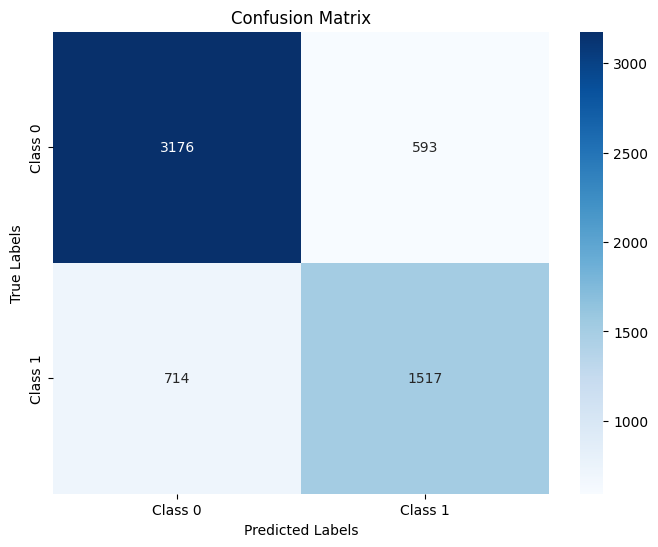

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      3769
           1       0.72      0.68      0.70      2231

    accuracy                           0.78      6000
   macro avg       0.77      0.76      0.76      6000
weighted avg       0.78      0.78      0.78      6000



In [787]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))


In [793]:
# # ## HPT

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [None, 10, 20],
#     'min_samples_leaf': [2, 4, 6],
# }

# grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', verbose=10, cv=2)

# grid_search.fit(X_train, y_train)


In [594]:
# best_model = random_search.best_estimator_
# print(random_search.best_params_)

# y_pred = best_model.predict(X_test)

# print('Train Accuracy', accuracy_score(y_train, rf.predict(X_train)))
# print('Test Accuracy', accuracy_score(y_test, y_pred))
# print('Precision', precision_score(y_test, y_pred))

In [595]:
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

# print("Classification Report:\n", classification_report(y_test, y_pred))


5. XG Boost

In [794]:
X_train = np.array(X_train)
xgb = XGBClassifier()
xgb.fit(np.array(X_train), np.array(y_train))
y_pred = xgb.predict(np.array(X_test))

print('Train Accuracy', accuracy_score(y_train, xgb.predict(X_train)))
print('Test Accuracy', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))

Train Accuracy 0.9839583333333334
Test Accuracy 0.789
Precision 0.7230698104484512


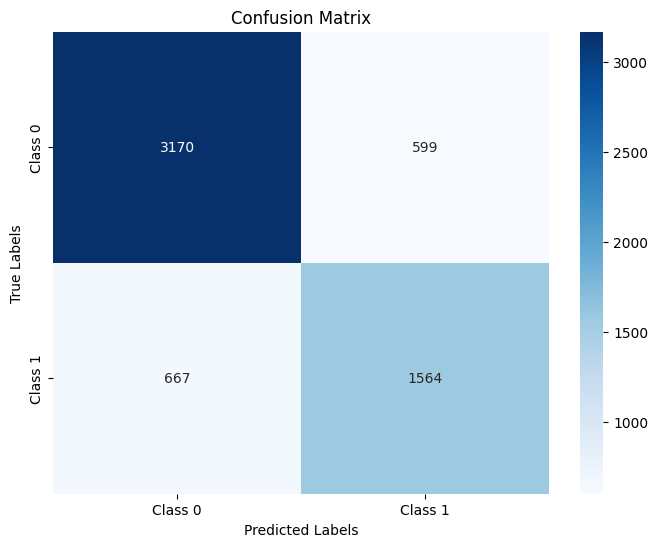

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      3769
           1       0.72      0.70      0.71      2231

    accuracy                           0.79      6000
   macro avg       0.77      0.77      0.77      6000
weighted avg       0.79      0.79      0.79      6000



In [796]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))


6. GBM

In [797]:
# gbm = GradientBoostingClassifier()
# gbm.fit(X_train, y_train)

# y_pred = gbm.predict(X_test)

# print('Accuracy', accuracy_score(y_test, y_pred))
# print('Precision', precision_score(y_test, y_pred))

In [798]:
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

# print("Classification Report:\n", classification_report(y_test, y_pred))

#### =================== for new input prediction ==========================

In [799]:
from nltk.corpus import stopwords


def test_get_token_features(q1, q2):

    SAFE_DIV = 0.0001

    token_features = [0.0]*8

    # get tokens in both questions
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    STOP_WORDS = stopwords.words('english')

    # get stopwords in both questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # get ordinary words (non-stopwords) in both questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    # number of common tokens in both questions
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    # number of common stop words in both tokens
    common_stopword_count = len(q1_stops.intersection(q2_stops))

    # number of common words in both tokens
    common_word_count = len(q1_words.intersection(q2_words))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count/ (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stopword_count/ (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stopword_count/ (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count/ (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count/ (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = 1 if (q1_tokens[-1] == q2_tokens[-1]) else 0
    token_features[7] = 1 if (q1_tokens[0] == q2_tokens[0]) else 0


    return token_features


In [800]:
import distance


def test_get_length_features(q1, q2):

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    length_features = [0.0]*3

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # mean token length
    length_features[0] = (len(q1_tokens) + len(q2_tokens))/2

    # absolute difference in length
    length_features[1] = abs(len(q1_tokens) - len(q2_tokens))

    # longest substring ratio
    substrs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(substrs[0]) / ( min(len(q1), len(q2)) + 1)
        
    return length_features


In [801]:
from fuzzywuzzy import fuzz

def test_get_fuzzy_features(q1, q2):

    fuzzy_features = [0.0]*4

    fuzzy_features[0] = fuzz.ratio(q1, q2)
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features



In [802]:
def test_total_words(q1, q2): 
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))

    return len(w1) + len(w2)

In [803]:
def test_common_words(q1, q2): 
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))

    return len(w1 & w2)

In [804]:
def query_point_creator(q1, q2):
    
    input_query_features = []

    #preprocessing the input questions
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # token based features
    token_features = test_get_token_features(q1, q2)
    input_query_features.extend(token_features)

    # length based features
    length_features = test_get_length_features(q1, q2)
    input_query_features.extend(length_features)

    # fuzzy features
    fuzzy_features = test_get_fuzzy_features(q1, q2)
    input_query_features.extend(fuzzy_features)

    # basic features
    input_query_features.append(len(q1))
    input_query_features.append(len(q2))
    
    input_query_features.append(len(q1.split()))
    input_query_features.append(len(q2.split()))

    input_query_features.append(test_total_words(q1, q2))
    input_query_features.append(test_common_words(q1, q2))
    input_query_features.append(test_common_words(q1, q2)/test_total_words(q1, q2))

    q1_embedding = sentence_to_vector(q1.split(" "), w2v, vector_size).reshape(1, -1)
    q2_embedding = sentence_to_vector(q2.split(" "), w2v, vector_size).reshape(1, -1)

    # q1_bow = cv.transform([q1]).toarray()
    # q2_bow = cv.transform([q2]).toarray()

    return np.hstack((np.array(input_query_features).reshape(1, 22), q1_embedding, q2_embedding))
    # return np.hstack((np.array(input_query_features).reshape(1, 22), q1_bow, q2_bow))
   
  

In [809]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'
q5 = 'How can I learn Python programming?'
q6 = 'What is the best way to learn Python programming?'
q7 = 'What are the benefits of exercising regularly?'
q8 = 'Why should I exercise every day?'
q9 = 'Who is the president of India?'
q10 = 'Who was the first president of France?'

In [812]:
query = query_point_creator(q5, q6)

rf.predict(query)[0]

1

In [814]:
import pickle

pickle.dump(rf, open('model/rf_model.pkl', 'wb'))
pickle.dump(w2v, open('model/w2v.pkl', 'wb'))
# pickle.dump(word2tfidf, open('word2tfidf.pkl', 'wb'))